In [1]:
import skimage.io
import dask.array as da
import dask
from dask import delayed
from pathlib import Path
import napari
from napari.utils import nbscreenshot
from natsort import natsorted
import numpy as np
from napari_flim_phasor_calculator._reader import get_current_tz
import zarr

Define read 2d and 3d functions

In [2]:
# folder_path = r"C:\Users\mazo260d\Desktop\Conni_BiA_PoL\embryo_FLIM_data\raw_data_embryo_stack_3tps_43pl_2ch\output_as_tif"
# folder_path = r"C:\Users\mazo260d\Desktop\Conni_BiA_PoL\stack_smaller_as_tif"
folder_path = r"C:\Users\mazo260d\Desktop\Conni_BiA_PoL\stack_as_tif"

folder_path = Path(folder_path)

Get max slice shape

In [3]:
# Read single tif file
def read_single_tif_file(path, channel_axis=0, ut_axis=1):
    from skimage.io import imread
    data = imread(path)
    # if not there already, move ch and ut from their given positions to 0 and 1 axes
    data = np.moveaxis(data, [channel_axis, ut_axis], [0, 1])
    # TO DO: allow external reading of metadata
    metadata_per_channel = []
    metadata = {}
    metadata['file_type'] = 'tif'
    for channel in range(data.shape[0]):
        metadata_per_channel.append(metadata)
    return data, metadata_per_channel

In [4]:
# Get list of file paths
file_paths = natsorted([file_path for file_path in folder_path.iterdir()])
suffixes = [p.suffix for p in folder_path.iterdir()]
if '.tif' in suffixes:
    file_extension = '.tif'
# Dictionary relating file extension to compatible reading function
get_read_function_from_extension = {
    '.tif': read_single_tif_file,
    # '.ptu': read_single_ptu_file,
    # '.sdt': read_single_sdt_file
}

def get_max_slice_shape_and_dtype(file_paths, file_extension):
    # TO DO: offer fast reading option by calculating max shape from metadata (array may become bigger)
    # Go through files to get max shape (number of photon bins may vary from image to image)
    shapes_list = []
    for file_path in file_paths:
        if file_path.suffix == file_extension:
            imread = get_read_function_from_extension[file_extension]
            image_slice, _ = imread(file_path)
            shapes_list.append(image_slice.shape) # (ch, ut, y, x)
    # Get slice max shape (ch, mt, y, x)
    return max(shapes_list), image_slice.dtype

image_slice_shape, image_dtype = get_max_slice_shape_and_dtype(file_paths, file_extension)

Get max z slices and max t timepoints from filepaths

In [5]:
def get_max_zslices(file_paths):
    max_z = max([get_current_tz(file_path) for file_path in file_paths])[1]
    if max_z is None:
        return 1
    return max_z

def get_max_time(file_paths):
    max_time = max([get_current_tz(file_path) for file_path in file_paths])[0]
    if max_time is None:
        return 1
    return max_time

# Get maximum time and z from file names
max_z = get_max_zslices(file_paths)
print('max_z slices = ', max_z)
max_t = get_max_time(file_paths)
print('max_time = ', max_t)

# # Get zstack max shape (ch, mt, z, y, x)
# image_stack_shape = (*image_slice_shape[:-2], max_z, *image_slice_shape[-2:])

max_z slices =  65
max_time =  1


In [7]:
stack_shape = (*image_slice_shape[:-2], max_t, max_z, *image_slice_shape[-2:])
stack_shape

(2, 276, 1, 65, 512, 512)

Get list of paths

In [8]:
def get_structured_list_of_paths(file_paths, file_extension):
    t_path_list = []
    z_path_list = []
    file_paths = natsorted(file_paths)
    previous_t = 1
    for file_path in file_paths:
        if file_path.suffix == file_extension:
            current_t, current_z = get_current_tz(file_path)
            if current_t is not None:
                if current_t > previous_t:
                    t_path_list.append(z_path_list)
                    z_path_list = []
                    previous_t = current_t
                z_path_list.append(file_path)
    # If no timepoints, z_path_list is file_paths
    if current_t is None:
        z_path_list = file_paths
    # Append last timepoint
    t_path_list.append(z_path_list)
    return t_path_list

list_of_time_point_paths = get_structured_list_of_paths(file_paths, '.tif')

In [9]:
stack_shape

(2, 276, 1, 65, 512, 512)

In [10]:
url = folder_path / (folder_path.stem + '.zarr')
# Using zarr to automatically guess chunk sizes
# The line below creates an empty zarr array of a specified shape and dtype filled with zeros
z1 = zarr.open(url, mode='w', shape=stack_shape, dtype=image_dtype)
# Using dask to rechunk micro-time axis
dask_array = da.from_zarr(url)
print(dask_array.chunks)
# Rechunk micro-time as a single chunk (for fft calculation afterwards)
dask_array = dask_array.rechunk(chunks={1: -1})
print(dask_array.chunks)
# Overwriting previous zarr rechunked
da.to_zarr(dask_array, url, overwrite=True)
# z = zarr.zeros(stack_shape, path = url, dtype=image_2D.dtype)
# z1.shape

((1, 1), (35, 35, 35, 35, 35, 35, 35, 31), (1,), (9, 9, 9, 9, 9, 9, 9, 2), (64, 64, 64, 64, 64, 64, 64, 64), (128, 128, 128, 128))
((1, 1), (276,), (1,), (9, 9, 9, 9, 9, 9, 9, 2), (64, 64, 64, 64, 64, 64, 64, 64), (128, 128, 128, 128))


In [11]:
# Read zarr as read/write
z1 = zarr.open(url, mode='r+')

In [12]:
z1.chunks

(1, 276, 1, 9, 64, 128)

In [14]:
for i, z_paths in enumerate(list_of_time_point_paths):
    for j, path in enumerate(z_paths):
        data, _ = read_single_tif_file(path)
        z1[:data.shape[0],:data.shape[1], i, j, :data.shape[2], :data.shape[3]] = data

In [15]:
viewer = napari.Viewer()

In [16]:
viewer.add_image(z1, channel_axis=0)

[<Image layer 'Image' at 0x2120c2e2d90>,
 <Image layer 'Image [1]' at 0x2120cab8fd0>]

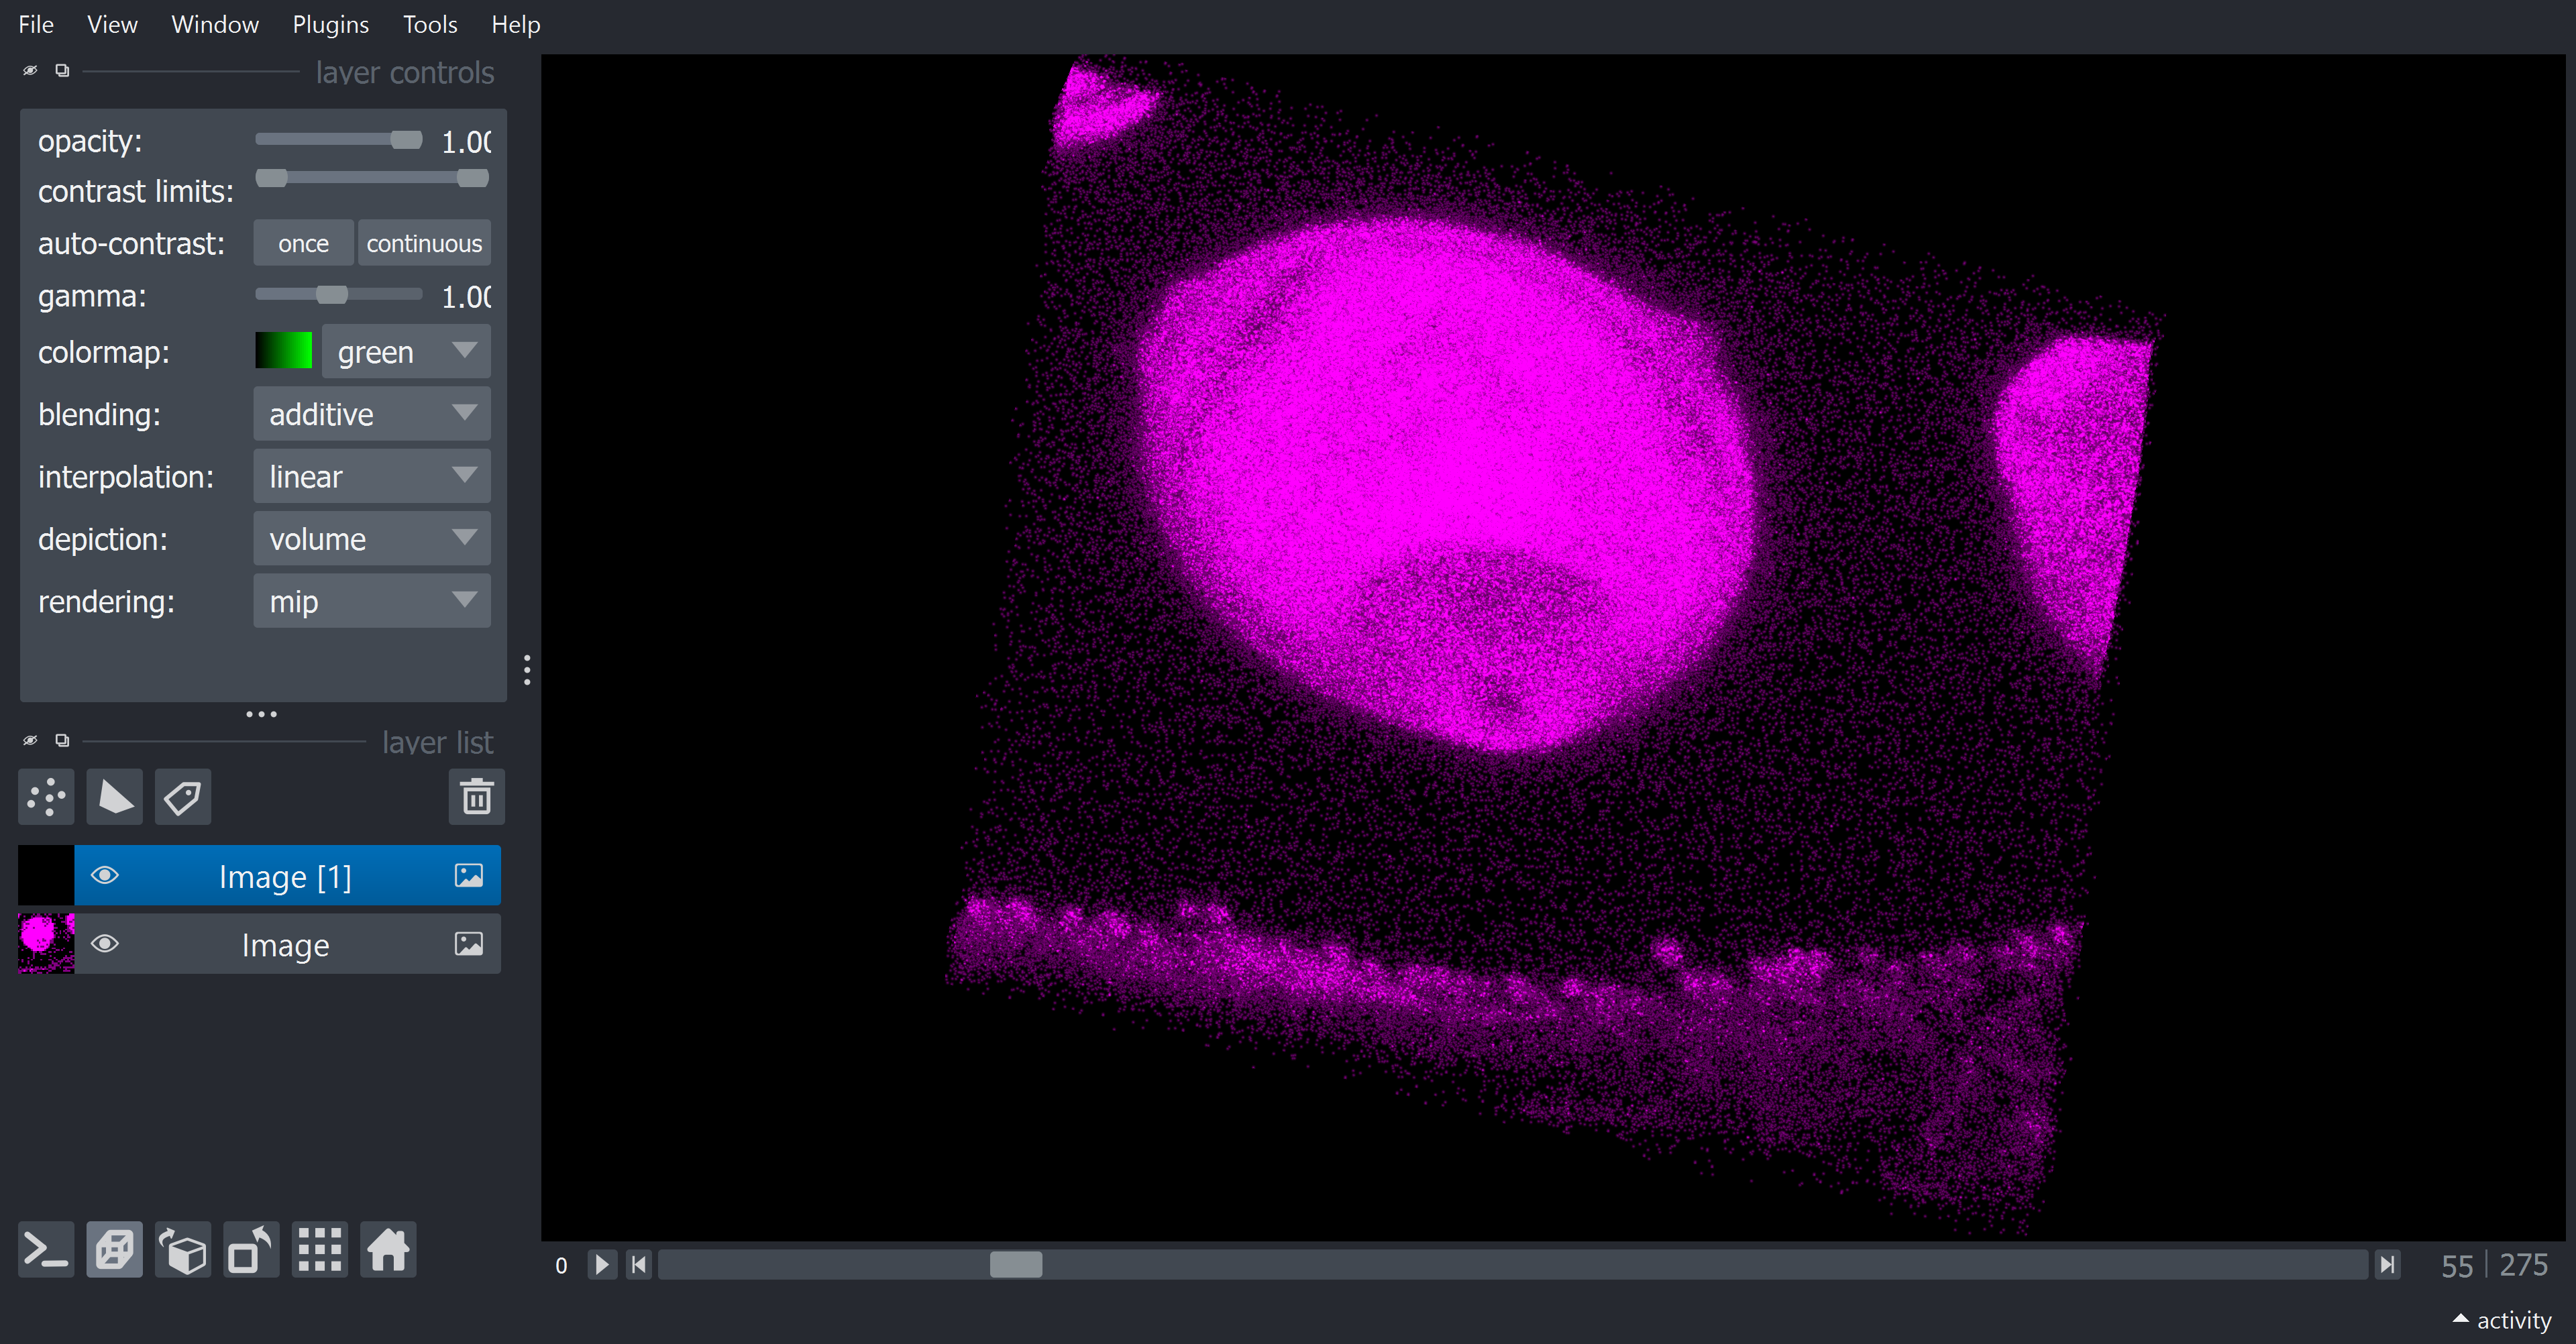

In [18]:
nbscreenshot(viewer)